***
Code

# Data Pre-processing

In [1]:
#Customized data set bases on IEEE MATPOWER case33bw - 37 LINES
import numpy as np
#               fbus, tbus,   r  ,    x    
#                 (0) (1)    (2)     (3)   
LData = np.array([[1,   2, 0.0575, 0.0293],
                  [2,   3, 0.3076, 0.1567],
                  [3,   4, 0.2284, 0.1163],
                  [4,   5, 0.2378, 0.1211],
                  [5,   6,  0.511, 0.4411],
                  [6,   7, 0.1168, 0.3861],
                  [7,   8, 0.4439, 0.1467],
                  [8,   9, 0.6426, 0.4617],
                  [9,  10, 0.6514, 0.4617],
                  [10, 11, 0.1227, 0.0406],
                  [11, 12, 0.2336, 0.0772],
                  [12, 13, 0.9159, 0.7206],
                  [13, 14, 0.3379, 0.4448],
                  [14, 15, 0.3687, 0.3282],
                  [15, 16, 0.4656, 0.34],
                  [16, 17, 0.8042, 1.0738],
                  [17, 18, 0.4567, 0.3581],
                  [ 2, 19, 0.1023, 0.0976],
                  [19, 20, 0.9385, 0.8457],
                  [20, 21, 0.2555, 0.2985],
                  [21, 22, 0.4423, 0.5848],
                  [ 3, 23, 0.2815, 0.1924],
                  [23, 24, 0.5603, 0.4424],
                  [24, 25, 0.559, 0.4374],
                  [ 6, 26, 0.1267, 0.0645],
                  [26, 27, 0.1773, 0.0903],
                  [27, 28, 0.6607, 0.5826],
                  [28, 29, 0.5018, 0.4371],
                  [29, 30, 0.3166, 0.1613],
                  [30, 31, 0.608, 0.6008],
                  [31, 32, 0.1937, 0.2258],
                  [32, 33, 0.2128, 0.3308],
                  [21,  8, 1.2479, 1.2479],
                  [ 9, 15, 1.2479, 1.2479],
                  [12, 22, 1.2479, 1.2479],
                  [18, 33, 0.312, 0.312],
                  [10, 30, 0.312, 0.312],                        # New 6 : 10-29
                  [25, 29, 0.312, 0.312]])
#L = len(LData)
#print(L)
#MVAlim for 37 lines
MVAlim = np.array([270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270,
          270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270])
L = 38
fr_bus = LData[:,0]
to_bus = LData[:,1]
r      = LData[:,2]
x      = LData[:,3]

In [2]:
#Read bus data from MATPOWER
#CVXPY, MOSEK and GUROBI
import cvxpy as cvx
import numpy as np
import math
import gurobipy
# to run the following commands, please follow  https://www.instructables.com/id/Call-MATLAB-Script-and-Function-From-Python/
import matlab.engine
eng = matlab.engine.start_matlab()

#case = "case141"
case = "case33bw"
#case = "case22"
#case = "case18"
#case = "case33qiskit5"
#case = "case33qiskit3"
#case = "case4_dist"
#case = "case33bw_qiskit_13line"

ret = eng.Read_RadialNet_Matpower(case)  #case33bw, case123  # these command is equivalent to run Read_Matpower_Radial(case33bw) in Matlab
import scipy.io as spio #Reading Matlab mat data as Python dictionary
data = spio.loadmat('Radial_Netdata', squeeze_me=True) #taken from Matlab command Read_Matpower_Radial(Matpower_case_format);
#data contains the following parameters
#'Sbase', 'Pgmax', 'Pgmin', 'Qgmax', 'Qgmin', 'GenVarCost0', 'GenVarCost', 'G', 'B', 'MVAlim', 'connex', 'Pd', 'Qd', 'Vmax', 'Vmin','Gen2Bus'
#r = data['r']
#x = data['x']
slack_bus = 0
#slack_bus =55 #case 123 slackbus is 56 (Python index count from 0)
#slack_bus =113
I = len(data['Pd'])
G = data['G']
B = -data['B']
MVAlim =data['MVAlim']
status = data['status']

ModuleNotFoundError: No module named 'cvxpy'

Define a connex function to check whether a pair of node $i,j=\ell \in \mathcal{L}$

In [ ]:
def connex(i,j,LData): #return 1 of (i,j) or (j,i) is a "connected" line
    temp = False
    for line in range(L):
        z1= (i== fr_bus[line]-1) and (j== to_bus[line]-1)
        z2= (j== fr_bus[line]-1) and (i== to_bus[line]-1)
        #z3= (data['status'][line]==1) #some lines are open switches
        #z= (z1 or z2) and z3
        z= (z1 or z2)
        temp = temp or z
    return temp

Normalize the data from MATPOWER

In [ ]:
print(MVAlim)
if case =="case18":
    scale = 10
else:
    scale = 1    
data['Sbase']= scale*data['Sbase']
r = r*scale
x = x*scale
data['gs'] = data['gs']/scale
data['bs'] = data['bs']/scale


[270 270 270 270 270 270 270 270 270 270 270 270 270 270 270 270 270 270
 270 270 270 270 270 270 270 270 270 270 270 270 270 270]


# Network reconfiguration model - Classical computing

In [ ]:
#CPLEX
import sys
import docplex.mp
from docplex.mp.model import Model
mdl = Model(name='Reconfiguration')

#Qiskit
from src.qiskit_optimization import QuadraticProgram
from src.qiskit_optimization.translators import from_docplex_mp

In [4]:
#Branch flow model of Farivar and S. Low (Cleaner version)

data = spio.loadmat('Radial_Netdata', squeeze_me=True)
mdl.clear()
#Power flow variables
P  = mdl.continuous_var_matrix(keys1=I, keys2=I, name='P')
Q  = mdl.continuous_var_matrix(keys1=I, keys2=I, name='Q')
v  = mdl.continuous_var_list(I, ub=1, name='v') #Remember to remove ub of v[i], (just temporarily added to force v <=1 for quantum)
Isq= mdl.continuous_var_list(L, lb=0, name='Isq')

#Variables for relaxation of Demand sastifaction. In case some demands cannot be served -> relax the Pd constraint
Pds = mdl.continuous_var_list(I, lb=0, name='Pds')
Pc  = mdl.continuous_var_list(I, lb=0, name='Pc')
Qds = mdl.continuous_var_list(I, lb=0, name='Qds')
Qc  = mdl.continuous_var_list(I, lb=0, name='Qc')

#Network reconfiguration setting
vl    = mdl.continuous_var_matrix(keys1=L, keys2=I, lb=0, name='vl')
alpha = mdl.binary_var_list(L, name='alpha')
beta  = mdl.continuous_var_matrix(keys1=I, keys2=I, lb=0, name='beta')

### CONSTRAINTS
#Faulted lines scenario
# faultline = [19, 25] #Case 1
# faultline = [8, 11, 19] #Case 2       # TEST 3
# faultline = [7, 11] #Case 3
# faultline = [3, 18] #Case 4             
# faultline = [21, 26] #Case 5
faultline = [10, 20] #Case 6          # TEST 2
# faultline = [22] #Case 7              # TEST 1
# faultline = []


Delta = [1 for line in range(L)]
for line in faultline:
    Delta[line] = 0

#Power balance
P_outflow_of = [0 for i in range(I)]
Q_outflow_of = [0 for i in range(I)]
P_inflow_of  = [data['gs'][i]*v[i] for i in range(I)]
Q_inflow_of  = [data['bs'][i]*v[i] for i in range(I)]

for j in range(I):
    for k in range(I):
        for line in range(L):
            if Delta[line]==1:
                if (j==fr_bus[line]-1) and (k==to_bus[line]-1):
                    P_outflow_of[j] += P[j,k]
                    Q_outflow_of[j] += Q[j,k]                   
for j in range(I):
    for i in range(I):
        for line in range(L):
            if Delta[line]==1:
                if (i==fr_bus[line]-1) and (j==to_bus[line]-1):
                    P_inflow_of[j] += (P[i,j] - r[line]*Isq[line])
                    Q_inflow_of[j] += (Q[i,j] - x[line]*Isq[line])                       

 #Demand = Curtailment + Demand served
mdl.add_constraints(data['Pd'][j]/data['Sbase'] == Pc[j] + Pds[j] for j in range(I) if j != slack_bus)
mdl.add_constraints(data['Qd'][j]/data['Sbase'] == Qc[j] + Qds[j] for j in range(I) if j != slack_bus)

mdl.add_constraints(-(P_outflow_of[j] - P_inflow_of[j]) == Pds[j] for j in range(I) if j !=slack_bus)
mdl.add_constraints(-(Q_outflow_of[j] - Q_inflow_of[j]) == Qds[j] for j in range(I) if j !=slack_bus)

#Radiality constraints
#Beta(i,j) = 1 for all j connected to node i
for i in range(I):
    mdl.add_constraint(mdl.sum(beta[i,j] for j in range(I) if connex(i,j,LData) == 1) <= 1)    #Beta[i,j] = 0 or 1

mdl.add_constraints(beta[0,j] == 0 for j in range(I) if connex(0,j,LData) == 1)             #Beta[0,j] = 0

#Sectionalizing switches + Tie switches
SW = [L-1, L-2, L-3, L-4, L-5, L-6]
print(L)

#Switching operation
for line in range(L):    
    i = int(fr_bus[line]-1)
    j = int(to_bus[line]-1)
    mdl.add_constraint(beta[i,j] <= 1) #Already set ub = 1
    mdl.add_constraint(beta[j,i] <= 1)
    if line in SW:
        mdl.add_constraint(alpha[line] == (beta[j,i] + beta[i,j]))
        mdl.add_constraint(alpha[line] <= Delta[line])
    else:
        mdl.add_constraint(Delta[line] == (beta[j,i]+beta[i,j]))

    if line in SW:
        #For sectionalizing switches and tie switches
        mdl.add_constraint(vl[line,i] <= ((data['Vmax'][i])**2)*alpha[line]) #0<=vl[line,i]<=Vmax*alpha[line]
        mdl.add_constraint(vl[line,j] <= ((data['Vmax'][j])**2)*alpha[line]) #0<=vl[line,j]<=Vmax*alpha[line]
        mdl.add_constraint((v[i]-vl[line,i]) >= 0)
        mdl.add_constraint((v[i]-vl[line,i]) <=((data['Vmax'][i])**2)*(1-alpha[line]))  #0<=v[i]-vl[line,i]<=Vmax^2*(1-alpha[line])
        mdl.add_constraint((v[j]-vl[line,j]) >= 0)
        mdl.add_constraint((v[j]-vl[line,j]) <=((data['Vmax'][j])**2)*(1-alpha[line]))  #0<=v[j]-vl[line,j]<=Vmax^2*(1-alpha[line])
    else:
        #For non-sectionalizing switches
        mdl.add_constraint(vl[line,i] <= ((data['Vmax'][i])**2)*Delta[line]) #0<=vl[line,i]<=Vmax*Delta[line]
        mdl.add_constraint(vl[line,j] <= ((data['Vmax'][j])**2)*Delta[line]) #0<=vl[line,j]<=Vmax*Delta[line]
        mdl.add_constraint((v[i]-vl[line,i]) >= 0)
        mdl.add_constraint((v[i]-vl[line,i]) <=((data['Vmax'][i])**2)*(1-Delta[line]))  #0<=v[i]-vl[line,i]<=Vmax^2*(1-Delta[line])
        mdl.add_constraint((v[j]-vl[line,j]) >= 0)
        mdl.add_constraint((v[j]-vl[line,j]) <=((data['Vmax'][j])**2)*(1-Delta[line]))  #0<=v[j]-vl[line,j]<=Vmax^2*(1-Delta[line])

#=======================================================================================================================

#"""
aux1 = mdl.continuous_var_list(L, name='aux1') 
aux2 = mdl.continuous_var_list(L, name='aux2') 

for line in range(L):
    i = int(fr_bus[line]-1)
    j = int(to_bus[line]-1)
    if Delta[line] == 1:
        mdl.add_constraint(aux1[line] == 0.5*(vl[line,i] - Isq[line]))
        mdl.add_constraint(aux2[line] == 0.5*(vl[line,i] + Isq[line]))
#""" 

#Voltage drop and Conic constraint
for line in range(L):
    if Delta[line] == 1:
        i = int(fr_bus[line]-1)
        j = int(to_bus[line]-1)
        mdl.add_constraint(vl[line,j] == vl[line,i] - 2*(r[line]*P[i,j] + x[line]*Q[i,j]) + (r[line]**2 + x[line]**2)*Isq[line])
        #mdl.add_constraint(P[i,j]**2 + Q[i,j]**2 <= vl[line,i] * Isq[line])
        mdl.add_constraint((P[i,j]**2 + Q[i,j]**2 + (aux1[line])**2) <= (aux2[line])**2)

#Voltage limit constraint
#mdl.add_constraints(v[i] >= (data['Vmin'][i])**2 for i in range(I) if i!=slack_bus)
#mdl.add_constraints(v[i] <= (data['Vmax'][i])**2 for i in range(I) if i!=slack_bus)
for i in range(I): 
    if i!=slack_bus:
        mdl.add_constraint(v[i] >= (data['Vmin'][i])**2)
        mdl.add_constraint(v[i] <= (data['Vmax'][i])**2)

if case == "case18":
    mdl.add_constraint(v[slack_bus] == 1.1)
else:
    mdl.add_constraint(v[slack_bus] == 1)

#Objective function
Pgrid = P_outflow_of[slack_bus]*data['Sbase']
Qgrid = Q_outflow_of[slack_bus]*data['Sbase']

VOLL= 1000
ENS = data['Sbase']*(mdl.sum(Pc[j] for j in range(I) if j != slack_bus)) #Energy not served

mdl.minimize(Pgrid + ENS*VOLL)

mdl.print_information()
mdl.solve(clean_before_solve=True, log_output=True)
# mdl.report()
# mdl.print_solution()

# """
print('Pgrid = ',Pgrid.solution_value)
print('Bus \t sum_Vl \t \t Vsq')
for i in range(I):
    print(i+1,'\t',sum(vl[line,i].solution_value for line in range(L)),'\t',v[i].solution_value)

print('L# \t Fr \t To \t Del \t Al \t Isq')
for line in range(L):
    print(str(line+1)+'\t'+str(fr_bus[line])+'\t'+str(to_bus[line])+'\t'+str(Delta[line])+'\t'+str(alpha[line].solution_value)+'\t'+str(Isq[line].solution_value))
# """

NameError: name 'spio' is not defined

In [5]:
# To be used for benchmarking plotting
type(Isq[line].solution_value)
Isq[1].solution_value
isq_cm = np.array([Isq[line].solution_value for line in range(L)])

for i in range(len(isq_cm)):
    print(isq_cm[i])

NameError: name 'Isq' is not defined

In [6]:
# To be used for benchmarking plotting
# type(v[i].solution_value)
v[1].solution_value
v_cm = np.array([v[i].solution_value for i in range(33)])

for j in range(len(v_cm)):
    print(v_cm[j])

NameError: name 'v' is not defined

# Quantum computing

## Check conflicted constraints

Make sure there is no SOS1, SOS2 constraints in the model

In [7]:
import docplex.mp.conflict_refiner as cr
solve_status = mdl.get_solve_status()
if solve_status.name == 'INFEASIBLE_SOLUTION':  # or also 'INFEASIBLE_OR_UNBOUNDED_SOLUTION'
    cref = cr.ConflictRefiner()
    print('show some of the constraints that can be removed to arrive at a minimal conflict')
    cref.refine_conflict(mdl, display=True)  # display flag is to show the conflicts

NameError: name 'mdl' is not defined

In [ ]:
#print(mdl.export_as_lp_string())
print('Pgrid = ',Pgrid.solution_value)
print('Bus \t sum_Vl \t \t Vsq')
for i in range(I):
    print(i+1,'\t',sum(vl[line,i].solution_value for line in range(L)),'\t',v[i].solution_value)

print('L# \t Fr \t To \t Del \t Al \t Isq')
for line in range(L):
    print(str(line+1)+'\t'+str(fr_bus[line])+'\t'+str(to_bus[line])+'\t'+str(Delta[line])+'\t'+str(alpha[line].solution_value)+'\t'+str(Isq[line].solution_value))

Pgrid =  3.485810444771447
Bus 	 sum_Vl 	 	 Vsq
1 	 1.0 	 1.0
2 	 2.9878482371101796 	 0.9959494123700599
3 	 2.93019306491618 	 0.9767310216387267
4 	 1.9345729745963505 	 0.9672864872981752
5 	 1.9161623868953264 	 0.9580811934476632
6 	 2.8170299206441562 	 0.939009973548052
7 	 1.873999180021054 	 0.936999590010527
8 	 1.8626311077874136 	 0.9313155538937068
9 	 2.7769976607100135 	 0.9256658869033378
10 	 1.8485853918892152 	 0.9242926959446076
11 	 0.9241820009659901 	 0.9241820009659901
12 	 0.9188608388850938 	 0.9188608388850938
13 	 1.8377216772772265 	 0.9188608386386132
14 	 1.8377216772772265 	 0.9188608386386132
15 	 2.7565825244945534 	 0.9188608414981845
16 	 1.8337905184004042 	 0.9168952592002021
17 	 1.82893306687607 	 0.914466533438035
18 	 0.9136418925561068 	 0.9136418925561068
19 	 1.9907637189365828 	 0.9953818594682914
20 	 1.983830425041192 	 0.991915212520596
21 	 0.9914364317628923 	 0.9914364317628923
22 	 0 	 0.81
23 	 1.9428714636691928 	 0.97143573183459

## Set up connect to IBMQ Cloud service

In [ ]:
# Import Qiskit libaries
# Import Qiskit libraries from the modified version in .src
from src.qiskit import IBMQ, Aer
from src.qiskit.algorithms import QAOA, VQE, NumPyMinimumEigensolver
from src.qiskit.algorithms.optimizers import COBYLA
from src.qiskit.utils import QuantumInstance, algorithm_globals
from src.qiskit.providers.aer.noise.noise_model import NoiseModel

# Import optimization-related modules from the modified version in .src
from src.qiskit_optimization import QuadraticProgram
from src.qiskit_optimization.algorithms import MinimumEigenOptimizer
from src.qiskit_optimization.converters import QuadraticProgramToQubo


C:\Users\ango1\AppData\Local\Temp\ipykernel_14780\2270211978.py:3: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms import QAOA, VQE, NumPyMinimumEigensolver


In [ ]:
#Run this command only once when receiving it from IBMQ. This command is to save token in PC, otherwise run IBMQ.update_account()
# IBMQ.save_account('449340a846e733ba9acd11130b2ae2aebbc21ff321b5cc91adce91f84f09f7cabcc135fb7df6112cb3c867d171482d6144bfe836122a7f9ec93457a02892a828', overwrite=True) 

In [ ]:
#Check loading status and current active account
# IBMQ.active_account()

In [ ]:
#Run directly, the token is not saved in local PC. This kind of provider would be deleted once the notebook is closed.
# provider = IBMQ.enable_account('449340a846e733ba9acd11130b2ae2aebbc21ff321b5cc91adce91f84f09f7cabcc135fb7df6112cb3c867d171482d6144bfe836122a7f9ec93457a02892a828')
# backend_real = provider.get_backend('ibm_kyoto')

In [ ]:
from qiskit import IBMQ
# IBMQ.update_account()

### Choose a real quantum computer

Maxium number of qubits for free usage is 7. If your problem has many binary variables, you should consider to use a simulator, instead.

In [ ]:
#Load account and specify the server we want to use. Check the online composer before giving this information to get_backend
#Current available FREE servers: 7qubits: ibm_nairobi, ibm_oslo; 5qubits: manila, quito, belem, lima; 1qubit: armonk
provider = IBMQ.load_account()
#backend_real = provider.get_backend('ibm_nairobi') # The system was retired!!!!


provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# device = provider.get_backend('QC NAME')
cloud_server  = provider.get_backend("ibm_kyoto")
# backend_real = provider.get_backend('simulator_stabilizer')

C:\Users\ango1\AppData\Local\Temp\ipykernel_14780\3613560080.py:3: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  provider = IBMQ.load_account()
C:\Users\ango1\AppData\Local\Temp\ipykernel_14780\3613560080.py:3: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


### Choose a simulator

In [ ]:
#This links with IBM Circuit online
# from qiskit import IBMQ, assemble, transpile
# from qiskit.circuit.random import random_circuit
# provider = IBMQ.load_account()
# backend_real = provider.backend.ibmq_qasm_simulator
# backend_real = provider.backend.simulator_stabilizer

## Using ADMM - Grover
ADMM algorithm is employed to decompose the Mixed-integer Convex Program into
- Quadratic Unconstrained Binary Optimization Subproblem (QUBO). QUBO is solved by QAOA algorithm or Grover algorithm
- Convex Program is solved by a classical solver such as Gurobi or CPLEX

In [ ]:
print('ADMMOptimizer')
import time
from typing import List, Optional, Any
from docplex.mp.model import Model

# Importing modified Qiskit libraries from .src
from src.qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from src.qiskit_optimization.algorithms import (
    CobylaOptimizer,
    MinimumEigenOptimizer,
    GroverOptimizer,
    ADMMParameters,
    ADMMOptimizer,
    CplexOptimizer  # Uncomment to use CPLEX instead
    # GurobiOptimizer,  # Uncomment to use GUROBI instead
)
from src.qiskit_optimization.problems import QuadraticProgram
from src.qiskit_optimization.translators import from_docplex_mp

# Define solver for QUBO subproblems

## Using QAOA
# qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=BasicAer.get_backend("statevector_simulator")))
# Using Quantum computer
backend_real = cloud_server
# qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=backend_real))
# quantum_instance_real = QuantumInstance(backend_real, shots=2048)
# qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=quantum_instance_real, optimizer=COBYLA()))

## Using Grover
from qiskit.primitives import Sampler
from qiskit.primitives import BackendSampler
# samplerGrover = Sampler(backend=backend_real)
samplerGrover = BackendSampler(backend_real)
grover = GroverOptimizer(6, num_iterations = 10**5, sampler=samplerGrover)



# Define solver for Continuous subproblems
#cobyla = CobylaOptimizer()
cplex = CplexOptimizer() # uncomment to use CPLEX instead
# gurobi = GurobiOptimizer()

# Convert mdl to MICP for ADMM optimizers
mod = from_docplex_mp(mdl)
#print(mod.export_as_lp_string())

# Set up parameters for ADMM
#admm_params = ADMMParameters(rho_initial=1001, beta=1000, factor_c=900, maxiter=100, three_block=True, tol=1.0e-6)
admm_params = ADMMParameters(
    rho_initial=100000, beta=10000000, factor_c=90000, maxiter=100000, vary_rho=1, max_time=100000, three_block=True, tol=1.0e-2, warm_start=True)


# Select solver for QUBO subproblems
# qubo_optimizer = qaoa
qubo_optimizer = grover
#qubo_optimizer = cplex  # uncomment to use CPLEX instead (If CPLEX is used for qubo, this problem is not quantum)

# Select solver for Continuous subproblems
# convex_optimizer = cobyla
convex_optimizer = cplex 
# convex_optimizer = gurobi
# convex_optimizer = spsa

# initialize ADMM with classical QUBO and convex optimizer
admm = ADMMOptimizer(params=admm_params, qubo_optimizer=qubo_optimizer, continuous_optimizer=convex_optimizer)


# =================================================================================================================
# run ADMM to solve problem
start_time = time.time()
result_Grover = admm.solve(mod)
print(result_Grover)
print("fval={:.2f}".format(result_Grover.fval))
#print("x={}".format(result))
print(result_Grover.variables_dict)
print("--- %s seconds ---" % (time.time() - start_time))

ADMMOptimizer
fval=528.2763512101841, P_0_0=0.0, P_0_1=0.032817112661909134, P_0_2=0.0, P_0_3=0.0, P_0_4=0.0, P_0_5=0.0, P_0_6=0.0, P_0_7=0.0, P_0_8=0.0, P_0_9=0.0, P_0_10=0.0, P_0_11=0.0, P_0_12=0.0, P_0_13=0.0, P_0_14=0.0, P_0_15=0.0, P_0_16=0.0, P_0_17=0.0, P_0_18=0.0, P_0_19=0.0, P_0_20=0.0, P_0_21=0.0, P_0_22=0.0, P_0_23=0.0, P_0_24=0.0, P_0_25=0.0, P_0_26=0.0, P_0_27=0.0, P_0_28=0.0, P_0_29=0.0, P_0_30=0.0, P_0_31=0.0, P_0_32=0.0, P_1_0=0.0, P_1_1=0.0, P_1_2=0.02995369870166194, P_1_3=0.0, P_1_4=0.0, P_1_5=0.0, P_1_6=0.0, P_1_7=0.0, P_1_8=0.0, P_1_9=0.0, P_1_10=0.0, P_1_11=0.0, P_1_12=0.0, P_1_13=0.0, P_1_14=0.0, P_1_15=0.0, P_1_16=0.0, P_1_17=0.0, P_1_18=0.0018012622248443425, P_1_19=0.0, P_1_20=0.0, P_1_21=0.0, P_1_22=0.0, P_1_23=0.0, P_1_24=0.0, P_1_25=0.0, P_1_26=0.0, P_1_27=0.0, P_1_28=0.0, P_1_29=0.0, P_1_30=0.0, P_1_31=0.0, P_1_32=0.0, P_2_0=0.0, P_2_1=0.0, P_2_2=0.0, P_2_3=0.01939912620872301, P_2_4=0.0, P_2_5=0.0, P_2_6=0.0, P_2_7=0.0, P_2_8=0.0, P_2_9=0.0, P_2_10=0.0, P

## Using ADMM - QAOA

In [ ]:
print('ADMMOptimizer')
import time
from typing import List, Optional, Any
from docplex.mp.model import Model

# Importing modified Qiskit libraries from .src
from src.qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from src.qiskit_optimization.algorithms import (
    CobylaOptimizer,
    MinimumEigenOptimizer,
    GroverOptimizer,
    ADMMParameters,
    ADMMOptimizer,
    CplexOptimizer  # Uncomment to use CPLEX instead
    # GurobiOptimizer,  # Uncomment to use GUROBI instead
)
from src.qiskit_optimization.problems import QuadraticProgram
from src.qiskit_optimization.translators import from_docplex_mp

# Define solver for QUBO subproblems
from qiskit.primitives import Sampler
from qiskit.primitives import BackendSampler
backend_real = cloud_server

## Using QAOA
# qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=BasicAer.get_backend("statevector_simulator")))
# Using Quantum computer
backend_real = cloud_server
# samplerGrover = BackendSampler(backend_real)

# qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=backend_real))
quantum_instance_real = QuantumInstance(backend_real, shots=2048, optimization_level = 3)
qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=quantum_instance_real, optimizer=COBYLA()))


## Using Grover
# from qiskit.primitives import Sampler
# from qiskit.primitives import BackendSampler
# samplerGrover = Sampler(backend=backend_real)
# samplerGrover = BackendSampler(backend_real)
# grover = GroverOptimizer(5, num_iterations = 10**5, sampler=samplerGrover)



# Define solver for Continuous subproblems
#cobyla = CobylaOptimizer()
cplex = CplexOptimizer() # uncomment to use CPLEX instead
# gurobi = GurobiOptimizer()

# Convert mdl to MICP for ADMM optimizers
mod = from_docplex_mp(mdl)
#print(mod.export_as_lp_string())

# Set up parameters for ADMM
#admm_params = ADMMParameters(rho_initial=1001, beta=1000, factor_c=900, maxiter=100, three_block=True, tol=1.0e-6)
admm_params = ADMMParameters(
    rho_initial=100000, beta=10000000, factor_c=90000, maxiter=100000, vary_rho=1, max_time=100000, three_block=True, tol=1.0e-2, warm_start=True)


# Select solver for QUBO subproblems
qubo_optimizer = qaoa
# qubo_optimizer = grover
#qubo_optimizer = cplex  # uncomment to use CPLEX instead (If CPLEX is used for qubo, this problem is not quantum)

# Select solver for Continuous subproblems
# convex_optimizer = cobyla
convex_optimizer = cplex 
# convex_optimizer = gurobi
# convex_optimizer = spsa

# initialize ADMM with classical QUBO and convex optimizer
admm = ADMMOptimizer(params=admm_params, qubo_optimizer=qubo_optimizer, continuous_optimizer=convex_optimizer)


# =================================================================================================================
# run ADMM to solve problem
start_time = time.time()
result_QAOA = admm.solve(mod)
print(result_QAOA)
print("fval={:.2f}".format(result_QAOA.fval))
#print("x={}".format(result))
print(result_QAOA.variables_dict)
print("--- %s seconds ---" % (time.time() - start_time))

ADMMOptimizer


C:\Users\ango1\AppData\Local\Temp\ipykernel_46392\2779394475.py:28: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance_real = QuantumInstance(backend_real, shots=2048, optimization_level = 3)
C:\Users\ango1\AppData\Local\Temp\ipykernel_46392\2779394475.py:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=quantum_instance_real, optimizer=COBYLA()))


fval=528.2763512101841, P_0_0=0.0, P_0_1=0.032817112661909134, P_0_2=0.0, P_0_3=0.0, P_0_4=0.0, P_0_5=0.0, P_0_6=0.0, P_0_7=0.0, P_0_8=0.0, P_0_9=0.0, P_0_10=0.0, P_0_11=0.0, P_0_12=0.0, P_0_13=0.0, P_0_14=0.0, P_0_15=0.0, P_0_16=0.0, P_0_17=0.0, P_0_18=0.0, P_0_19=0.0, P_0_20=0.0, P_0_21=0.0, P_0_22=0.0, P_0_23=0.0, P_0_24=0.0, P_0_25=0.0, P_0_26=0.0, P_0_27=0.0, P_0_28=0.0, P_0_29=0.0, P_0_30=0.0, P_0_31=0.0, P_0_32=0.0, P_1_0=0.0, P_1_1=0.0, P_1_2=0.02995369870166194, P_1_3=0.0, P_1_4=0.0, P_1_5=0.0, P_1_6=0.0, P_1_7=0.0, P_1_8=0.0, P_1_9=0.0, P_1_10=0.0, P_1_11=0.0, P_1_12=0.0, P_1_13=0.0, P_1_14=0.0, P_1_15=0.0, P_1_16=0.0, P_1_17=0.0, P_1_18=0.0018012622248443425, P_1_19=0.0, P_1_20=0.0, P_1_21=0.0, P_1_22=0.0, P_1_23=0.0, P_1_24=0.0, P_1_25=0.0, P_1_26=0.0, P_1_27=0.0, P_1_28=0.0, P_1_29=0.0, P_1_30=0.0, P_1_31=0.0, P_1_32=0.0, P_2_0=0.0, P_2_1=0.0, P_2_2=0.0, P_2_3=0.01939912620872301, P_2_4=0.0, P_2_5=0.0, P_2_6=0.0, P_2_7=0.0, P_2_8=0.0, P_2_9=0.0, P_2_10=0.0, P_2_11=0.0, P_2

## Using Quantum Random Access Optimization (Compress binaries to qubit)

In [ ]:
from src.qiskit.utils import QuantumInstance
from src.qiskit.algorithms.minimum_eigen_solvers import VQE
from src.qiskit.circuit.library import RealAmplitudes
from src.qiskit.algorithms.optimizers import SPSA
from src.qiskit_aer import Aer

from src.qrao import (
    QuantumRandomAccessOptimizer,
    QuantumRandomAccessEncoding,
    SemideterministicRounding,
    MagicRounding,
)
from qrao.utils import get_random_maxcut_qp


## ADMM----------------------------------------
print('ADMMOptimizer')
import time
from typing import List, Optional, Any
from docplex.mp.model import Model

# Importing modified Qiskit libraries from .src
from src.qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from src.qiskit_optimization.algorithms import (
    CobylaOptimizer,
    MinimumEigenOptimizer,
    GroverOptimizer,
    ADMMParameters,
    ADMMOptimizer,
    CplexOptimizer  # Uncomment to use CPLEX instead
    # GurobiOptimizer,  # Uncomment to use GUROBI instead
)
from src.qiskit_optimization.problems import QuadraticProgram
from src.qiskit_optimization.translators import from_docplex_mp

# Define solver for QUBO subproblems using modified Qiskit libraries
from src.qiskit.primitives import Sampler, BackendSampler
backend_real = cloud_server

#--------------------------------------------------------------------------------------------------
## Using QAOA
## Using Quantum computer
# backend_real = cloud_server
quantum_instance_real = QuantumInstance(backend_real, shots=2048, optimization_level = 3)
qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=quantum_instance_real, optimizer=COBYLA()))


#--------------------------------------------------------------------------------------------------
"""
## Using Random access
from qrao import (
    QuantumRandomAccessOptimizer,
    QuantumRandomAccessEncoding,
    SemideterministicRounding,
    MagicRounding,
)


# Create fake model
problem = get_random_maxcut_qp(degree=3, num_nodes=6, seed=1, draw=True)
# Create and encode the problem using the (3,1,p)-QRAC
encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)
encoding.encode(problem)


## Create and encode the problem using the (3,1,p)-QRAC
# encoding = QuantumRandomAccessEncoding(max_vars_per_qubit=3)
# mod = from_docplex_mp(mdl)
# encoding.encode(mod)
## Create a QuantumInstance for solving the relaxed Hamiltonian using VQE
relaxed_qi = QuantumInstance(backend=backend_real, shots=500)

## Create a QuantumInstance for magic rounding
rounding_qi = QuantumInstance(backend=backend_real, shots=1000)

# Set up the variational quantum eigensolver (ansatz width is determined by the encoding)
vqe = VQE(
    ansatz=RealAmplitudes(encoding.num_qubits),
    optimizer=SPSA(maxiter=50),
    quantum_instance=relaxed_qi,
)

# Use magic rounding
rounding_scheme = MagicRounding(rounding_qi)

# Construct the optimizer
from qrao.utils import get_random_maxcut_qp
problem = get_random_maxcut_qp(degree=3, num_nodes=6, seed=1, draw=True)
encoding.encode(problem)
qrao = QuantumRandomAccessOptimizer(encoding=encoding, min_eigen_solver=vqe, rounding_scheme=rounding_scheme)
"""
#--------------------------------------------------------------------------------------------------


# Define solver for Continuous subproblems
cplex = CplexOptimizer() # uncomment to use CPLEX instead
# gurobi = GurobiOptimizer()

# Convert mdl to MICP for ADMM optimizers
mod = from_docplex_mp(mdl)
#print(mod.export_as_lp_string())

# Set up parameters for ADMM
#admm_params = ADMMParameters(rho_initial=1001, beta=1000, factor_c=900, maxiter=100, three_block=True, tol=1.0e-6)
admm_params = ADMMParameters(
    rho_initial=100000, beta=10000000, factor_c=90000, maxiter=100000, vary_rho=1, max_time=100000, three_block=True, tol=1.0e-2, warm_start=False)


# Select solver for QUBO subproblems
qubo_optimizer = qaoa
# qubo_optimizer = qrao


# Select solver for Continuous subproblems
convex_optimizer = cplex 
# convex_optimizer = gurobi

# initialize ADMM with classical QUBO and convex optimizer
admm = ADMMOptimizer(params=admm_params, qubo_optimizer=qubo_optimizer, continuous_optimizer=convex_optimizer)


# =================================================================================================================
# run ADMM to solve problem
start_time = time.time()
result_QRAO = admm.solve(mod)
print(result_QRAO)
print("fval={:.2f}".format(result_QRAO.fval))
#print("x={}".format(result))
print(result_QRAO.variables_dict)
print("--- %s seconds ---" % (time.time() - start_time))



ADMMOptimizer


C:\Users\ango1\AppData\Local\Temp\ipykernel_14780\887322793.py:41: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance_real = QuantumInstance(backend_real, shots=2048, optimization_level = 3)
C:\Users\ango1\AppData\Local\Temp\ipykernel_14780\887322793.py:42: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=quantum_instance_real, optimizer=COBYLA()))


fval=333.69371014542287, P_0_0=0.0, P_0_1=0.036937825701041246, P_0_2=0.0, P_0_3=0.0, P_0_4=0.0, P_0_5=0.0, P_0_6=0.0, P_0_7=0.0, P_0_8=0.0, P_0_9=0.0, P_0_10=0.0, P_0_11=0.0, P_0_12=0.0, P_0_13=0.0, P_0_14=0.0, P_0_15=0.0, P_0_16=0.0, P_0_17=0.0, P_0_18=0.0, P_0_19=0.0, P_0_20=0.0, P_0_21=0.0, P_0_22=0.0, P_0_23=0.0, P_0_24=0.0, P_0_25=0.0, P_0_26=0.0, P_0_27=0.0, P_0_28=0.0, P_0_29=0.0, P_0_30=0.0, P_0_31=0.0, P_0_32=0.0, P_1_0=0.0, P_1_1=0.0, P_1_2=0.033154918315579505, P_1_3=0.0, P_1_4=0.0, P_1_5=0.0, P_1_6=0.0, P_1_7=0.0, P_1_8=0.0, P_1_9=0.0, P_1_10=0.0, P_1_11=0.0, P_1_12=0.0, P_1_13=0.0, P_1_14=0.0, P_1_15=0.0, P_1_16=0.0, P_1_17=0.0, P_1_18=0.0027040292825913576, P_1_19=0.0, P_1_20=0.0, P_1_21=0.0, P_1_22=0.0, P_1_23=0.0, P_1_24=0.0, P_1_25=0.0, P_1_26=0.0, P_1_27=0.0, P_1_28=0.0, P_1_29=0.0, P_1_30=0.0, P_1_31=0.0, P_1_32=0.0, P_2_0=0.0, P_2_1=0.0, P_2_2=0.0, P_2_3=0.02253610305222722, P_2_4=0.0, P_2_5=0.0, P_2_6=0.0, P_2_7=0.0, P_2_8=0.0, P_2_9=0.0, P_2_10=0.0, P_2_11=0.0, P

## Visualization

In [ ]:
import pandas as pd

admm_dict = result_QRAO.variables_dict
# admm_dict = result_QAOA.variables_dict

admm_df = pd.DataFrame(list(admm_dict.values()), index=admm_dict.keys(), columns=['Value'])
# Current magnitude results:
# Note: Use the Boolean array from .str.contains('Isq') to filter the DataFrame
isq_filter = admm_df.index.str.contains('Isq')
isq_data = admm_df[isq_filter]
# Note: Now, convert the filtered DataFrame's values to a NumPy array
isq_qm = isq_data['Value'].to_numpy()
print(isq_qm)

In [ ]:
# Voltage results

v_filter = admm_df.index.str.contains('v_')
v_data = admm_df[v_filter]
# Now, convert the filtered DataFrame's values to a NumPy array
v_qm = v_data['Value'].to_numpy()
print(v_qm)
len(v_qm)

[1.         0.99611837 0.97739453 0.96835502 0.95957197 0.94125768
 0.93920746 0.93388476 0.92868351 0.8926322  0.8926322  0.8926322
 0.97123598 0.97123598 0.97123605 0.96864442 0.965067   0.96365827
 0.99567132 0.99361745 0.8816431  0.8816431  0.9720368  0.96245274
 0.95767566 0.93900827 0.93608207 0.92591901 0.91888023 0.91526371
 0.91072055 0.90986158 0.90981935]


33

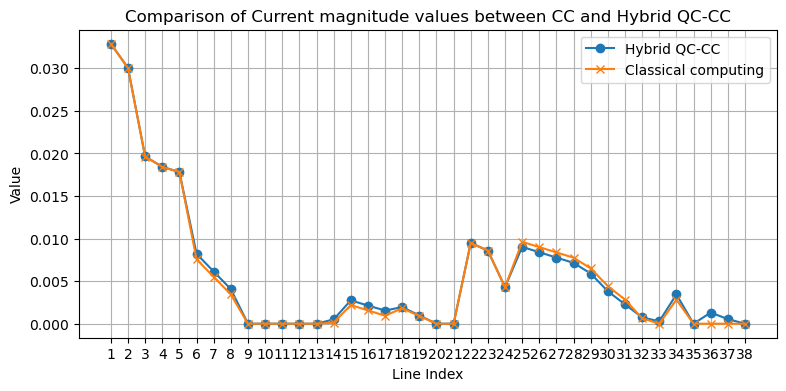

In [ ]:
import matplotlib.pyplot as plt

# Plotting the data
plt.figure(figsize=(9, 4))  # Set the figure size for better readability
x_axis = np.arange(1, len(isq_qm) + 1)
plt.plot(x_axis, np.sqrt(isq_qm), label='Hybrid QC-CC', marker='o')
plt.plot(x_axis, np.sqrt(isq_cm), label='Classical computing', marker='x')

# Adding some plot decorations
plt.title('Comparison of Current magnitude values between CC and Hybrid QC-CC')
plt.xlabel('Line Index')
plt.ylabel('Value')
plt.xticks(x_axis)
plt.legend()  # Show legend to identify the lines
plt.grid(True)  # Show grid for better readability

# Show the plot
plt.savefig('Isq.png')
plt.show()
# Save the plot
plt.close()

In [8]:
# Export data
for i in range(len(isq_qm)):
    print(np.sqrt(isq_qm[i]))
    
# for i in range(len(isq_cm)):
#     print(np.sqrt(isq_cm[i]))

NameError: name 'isq_qm' is not defined

In [9]:
import matplotlib.pyplot as plt

# Plotting the data
plt.figure(figsize=(9, 4))  # Set the figure size for better readability
x_axis = np.arange(1, len(v_qm) + 1)
plt.plot(x_axis, np.sqrt(v_qm), label='Hybrid QC-CC', marker='o')
plt.plot(x_axis, np.sqrt(v_cm), label='Classical computing', marker='x')

# Adding some plot decorations
plt.title('Comparison of Voltage values between CC and Hybrid QC-CC')
plt.xlabel('Bus Index')
plt.ylabel('Value')
plt.xticks(x_axis)
plt.legend()  # Show legend to identify the lines
plt.grid(True)  # Show grid for better readability

# Show the plot
plt.savefig('voltage.png')
plt.show()
# Save the plot
plt.close()

NameError: name 'v_qm' is not defined

<Figure size 900x400 with 0 Axes>

In [ ]:
# Export data
for i in range(len(v_qm)):
    print(np.sqrt(v_qm[i]))
    
# for i in range(len(v_cm)):
#     print(np.sqrt(v_cm[i]))

1.0
0.9980572961528726
0.9886326570624351
0.9840503139016279
0.9795774430260404
0.9701843560208949
0.9691271616719072
0.9663771329186233
0.9636822685966729
0.9447921449151246
0.9447921449150922
0.9447921449150922
0.9855130561616953
0.9855130561616953
0.9855130890078392
0.9841973505328453
0.9823782345040981
0.9816609775869763
0.9978333149884211
0.9968036168877187
0.9389585166486474
0.9389585166486474
0.9859192660781413
0.9810467594460903
0.9786090438148751
0.9690243910095836
0.9675133426308715
0.9622468561379401
0.9585824083385064
0.9566941563471993
0.9543167967574757
0.9538666446156854
0.9538445114190668


# Circuit

## Try 01

In [10]:
from src.qiskit import Aer, execute, QuantumCircuit
from src.qiskit.circuit import Parameter
gamma, beta = Parameter('gamma'), Parameter('beta')

qc = QuantumCircuit(1)
qc.h(0)
qc.barrier()
qc.rz(gamma, 0)
qc.rx(beta, 0)
qc.barrier()
qc.draw()

ModuleNotFoundError: No module named 'src'

In [11]:
def construct_schedule(T, N):
    delta_t = T/N
    gammas, betas = [], []  # H_C, H_X parameters
    for i in range(N+1):
        t = i * delta_t
        gammas += [ 2 * delta_t * t/T ]  # H_C
        betas += [ -2 * delta_t * (1 - t/T) ]  # H_X
    return gammas, betas

In [12]:
T = 5
N = 10
gammas, betas = construct_schedule(T, N)

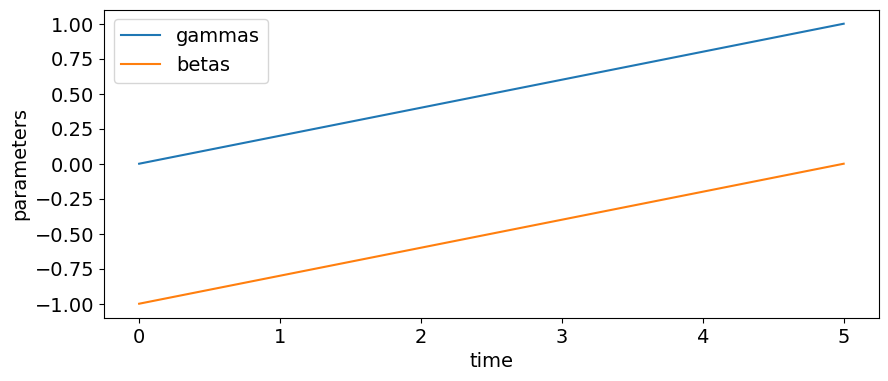

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, T, N+1), gammas, label='gammas')
plt.plot(np.linspace(0, T, N+1), betas, label='betas')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('time', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('parameters', fontsize=14);

In [14]:
from src.qiskit import QuantumCircuit
from src.qiskit.quantum_info import Statevector
import numpy as np

# Example definitions of gammas and betas
gammas = np.linspace(0, np.pi, 10) # Replace with your actual values
betas = np.linspace(0, np.pi/2, 10) # Replace with your actual values

N = 17 # Number of qubits
num_steps = len(gammas) # Assuming gammas and betas have the same length

# Adjust the probabilities array to have the right shape
probabilities = np.zeros((2**N, num_steps))

qc = QuantumCircuit(N)
qc.h(0)
qc.barrier()
for i, (gamma, beta) in enumerate(zip(gammas, betas)):
    qc.rz(gamma, i)
    qc.rx(beta, i)
    qc.barrier()
    # Update to fill the correct column in probabilities
    probabilities[:, i] = Statevector.from_instruction(qc).probabilities()

# If you want to visualize the circuit, use the draw method
print(qc.draw())  # Or qc.draw('mpl') for a matplotlib drawing if you're in a Jupyter environment


ModuleNotFoundError: No module named 'src'

## Try 02

In [15]:
# Built-in modules
import math
import warnings
warnings.filterwarnings("ignore")

# Imports from Qiskit
from src.qiskit import QuantumCircuit
from src.qiskit.circuit.library import GroverOperator, MCMT, ZGate
from src.qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
# from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Batch

ModuleNotFoundError: No module named 'src'

In [16]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

In [17]:
marked_states = ["00011", "00100"]

oracle = grover_oracle(marked_states)
grover_op = GroverOperator(oracle)
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits))))

NameError: name 'QuantumCircuit' is not defined

In [18]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()


NameError: name 'QuantumCircuit' is not defined

# Try 03

In [19]:
import numpy as np
from src.qiskit.visualization import plot_bloch_vector
 
# Use spherical coordinates to define the vector on the Bloch sphere
bloch_vector = [np.pi/3, np.pi/3, np.pi/2]

# Create the Bloch vector plot
fig = plot_bloch_vector(bloch_vector, coord_type='cartesian')

# Save the plot as a PNG file
fig.savefig('bloch_vector.png', dpi=300)

ModuleNotFoundError: No module named 'src'

In [20]:
## Multiple block
from src.qiskit.visualization import plot_bloch_vector
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = [3, 4])

states = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0.6, 0.8, 0],
    [0.6, 0, 0.8],
    [0, 0.6, 0.8],
]

# Values are in fractions of figure width and height:
positions = [
    [0, 0],
    [0.5, 0],
    [0, 0.333],
    [0.5, 0.333],
    [0, 0.667],
    [0.5, 0.667],
]

for m in range(len(states)):
    ax = fig.add_axes([positions[m][0], positions[m][1], 0.5, 0.333], axes_class = Axes3D)
    plot_bloch_vector(states[m], ax = ax)

ModuleNotFoundError: No module named 'src'

In [21]:
from src.qiskit.visualization import plot_bloch_vector
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = [1, 2])


# ax = fig.add_axes(axes_class = Axes3D)
plot_bloch_vector([np.pi/3, np.pi/3, np.pi/2])

ModuleNotFoundError: No module named 'src'

# Try 04

In [22]:
jid = "crtjgskdbt40008jrq2g"
job = provider.backend.retrieve_job(jid)

NameError: name 'provider' is not defined

In [23]:
# jobRes = job.result()
# resL=jobRes.results  
# nqc=len(resL)  # number of circuit in the job
# counts=jobRes.get_counts()
# if nqc==1: counts=[counts]  # this is poor design
# print('M: got %d circ+results'%nqc, 'JID=',jid)
# for ic in range(nqc):
#     qc=job.circuits()[ic]  # transpiled circuit 
#     resHead=resL[ic].header # auxiliary info about used hardware
#     print('\nM: circ=%d %s'%(ic,qc.name))
#     print('counts:',counts[ic])
#     q2_depth=qc.depth(filter_function=lambda x: x.operation.num_qubits > 1)
#     print('circuit q2_depth=%d , gate count:'%q2_depth,dict(qc.count_ops()))
#     print(qc.draw(output="text", idle_wires=False,fold=120))
#     print('result header: ',end=''); print(resHead)